# K-Soccer Football Object Detection Project Explanation

This is the explanation of the image processing and deep learning techniques used in this object detection project.
First, let's import the neccessary tools and libraries

In [21]:
import cv2
import time
import torch
import numpy as np
from ultralytics import YOLO
from collections import Counter
import os
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.cluster import KMeans

In [2]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("yolov8n.pt")


In [6]:
!yolo task=detect mode=predict model=yolov8n.pt source=media/image.png project=./runs conf=0.5

Ultralytics 8.3.7 🚀 Python-3.10.15 torch-2.4.1 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 c:\Users\DHO_d\OneDrive\Escritorio\football_ieee\K-Soccer\media\image.png: 640x640 6 persons, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 254.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


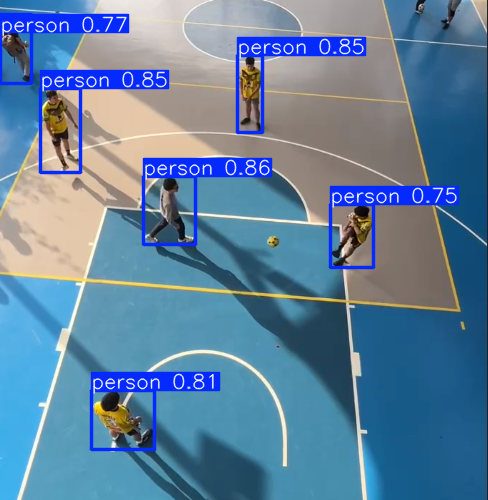

In [7]:
Image("runs/predict/image.png")

As we can see, the players are detected however the ball is not, we will fix this later on.
For now we can label the players with their corresponding class (team color) using the average color of each player box.

Let's plot each mean color.

In [3]:
results = yolo("media/image.png", classes = [0,32], conf = 0.5) # class 0 -> person, class 32 -> ball


image 1/1 c:\Users\DHO_d\OneDrive\Escritorio\football_ieee\K-Soccer\media\image.png: 640x640 6 persons, 7.8ms
Speed: 15.6ms preprocess, 7.8ms inference, 138.7ms postprocess per image at shape (1, 3, 640, 640)


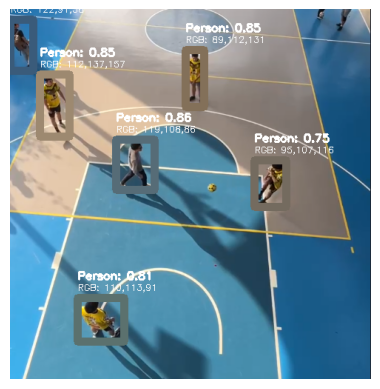

In [10]:
frame = cv2.imread("media/image.png")
player_colors = []
for result in results:
    boxes = result.boxes
    for box in boxes:

        # convert box attributes from tensor to arrays
        coords = box.xyxy.cpu().numpy()[0].astype(int)
        class_id = int(box.cls.cpu().numpy()[0])
        confidence = box.conf.cpu().numpy()[0]
        
        x1, y1, x2, y2 = coords
        
        # crop the frame with box coords
        crop_frame = frame[y1:y2, x1:x2]

    
        mean_color = np.mean(crop_frame, axis=(0,1)).astype(int)

        cv2.rectangle(frame, 
                            (x1, y1), 
                            (x2, y2), 
                            (int(mean_color[0]), int(mean_color[1]), int(mean_color[2])), 
                            10)

        label = f"{'Person' if class_id == 0 else 'Ball'}: {confidence:.2f}"
        color_text = f"RGB: {mean_color[0]},{mean_color[1]},{mean_color[2]}"
        cv2.putText(frame, 
                    label, 
                    (x1, y1 - 25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (255, 255, 255), 
                    2)
        cv2.putText(frame, 
                    color_text, 
                    (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.4, 
                    (255, 255, 255), 
                    1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

As seen, the floor color is interfering so we will center each box to detect only the T-shirts mean color.
 

Additionally we will assign each mean color to the nearest extreme color detected, using color distances techniques.

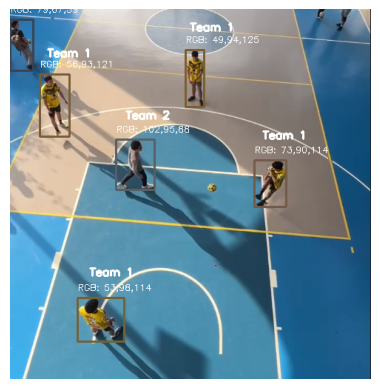

In [28]:
def color_distance(color1, color2):
    """Calculate Euclidean distance between two colors"""
    return np.sqrt(np.sum((color1 - color2) ** 2))

def assign_team(color, team_colors):
    """Assign a color to the closest team based on color distance"""
    if not team_colors.any():
        return 0
    distances = [color_distance(color, team_color) for team_color in team_colors]
    return np.argmin(distances)

def process_detections(frame, results):
        player_colors = []   
        player_boxes = []     

        for result in results:
            boxes = result.boxes
            for box in boxes:
                if len(box.xyxy) >= 1:

                    class_id = int(box.cls.cpu().numpy()[0])

                    if class_id == 0:
                        x1, y1, x2, y2 = box.xyxy.cpu().numpy()[0].astype(int)
                        # centering the box
                        mid_x = (x1 + x2) // 2
                        mid_y = (y1 + y2) // 2
                        half_height = (y2 - y1) // 2
                        half_width = (x2 - x1) // 2
                        centered_x1 = max(x1, mid_x - half_width // 2)
                        centered_x2 = min(x2, mid_x + half_width // 2)
                        centered_y1 = max(y1, mid_y - half_height // 2)
                        centered_y2 = min(y2, mid_y + half_height // 2)

                        crop_frame = frame[centered_y1:centered_y2, centered_x1:centered_x2]
                        mean_color = np.mean(crop_frame, axis=(0,1)).astype(int)
                        
                        
                        player_colors.append(mean_color)

                        player_boxes.append({
                        'coords': (centered_x1, centered_y1, centered_x2, centered_y2),
                        'color': mean_color,
                        })

                        cv2.rectangle(frame, 
                            (x1, y1), 
                            (x2, y2), 
                            (int(mean_color[0]), int(mean_color[1]), int(mean_color[2])), 
                            2)
                        
                        color_text = f"RGB: {mean_color[0]},{mean_color[1]},{mean_color[2]}"

                        cv2.putText(frame, 
                            color_text, 
                            (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.4, 
                            (255, 255, 255), 
                            1)
        
        # Use K-means to find team colors

        if len(player_colors) >= 2:
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(player_colors)
            team_colors = kmeans.cluster_centers_
        
            # Second pass: draw boxes with team colors
            for player in player_boxes:
                team = assign_team(player['color'], team_colors)
                x1, y1, x2, y2 = player['coords']                
                # Add team label
                label = f"Team {team+1}"
                
                cv2.putText(frame, 
                            label, 
                            (x1, y1 - 45), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (255, 255, 255), 
                            2)
               

        return frame, player_colors
        
frame = cv2.imread("media/image.png")
process_detections(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

We can improve the accuracy by overshadowing the color of the background